In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_parquet( '/content/drive/MyDrive/contest/data.parquet', engine='pyarrow')
test_loaded = pd.read_parquet('/content/drive/MyDrive/contest/test.parquet',engine='pyarrow')

# 기본 시계열 변수와 지하철 혼잡도 간의 상관분석

In [6]:
# 1) 시계열 변수
시계열변수 = [
    'day', 'day_of_year', 'hour', 'month',
    'week_of_month', 'week_of_year', 'weekday', 'year'
]

# 2) 삼각 변수
삼각변수 = [
    'sin_dom', 'cos_dom',
    'sin_dow', 'cos_dow',
    'sin_hod', 'cos_hod',
    'sin_wom', 'cos_wom',
    'sin_woy', 'cos_woy',
    'sin_doy', 'cos_doy'
]

# 3) 휴일·주말 변수
휴일주말변수 = [
    'is_day_before_holiday',
    'is_day_after_holiday',
    'is_holiday',
    'is_weekend'
]

# 4) 시간대 변수
시간대변수 = ['time_period']

# 5) 지하철 변수
지하철변수 = ['transfer', 'address','Direction', 'Line', 'STN', 'station_name', 'station_number', '신설역', '신규관측소']

# 6) 기상변수
기상변수 =  ['HM', 'RN_DAY', 'RN_HR1','TA', 'TM', 'WD','WS','ta_chi']

# 1. 상관분석

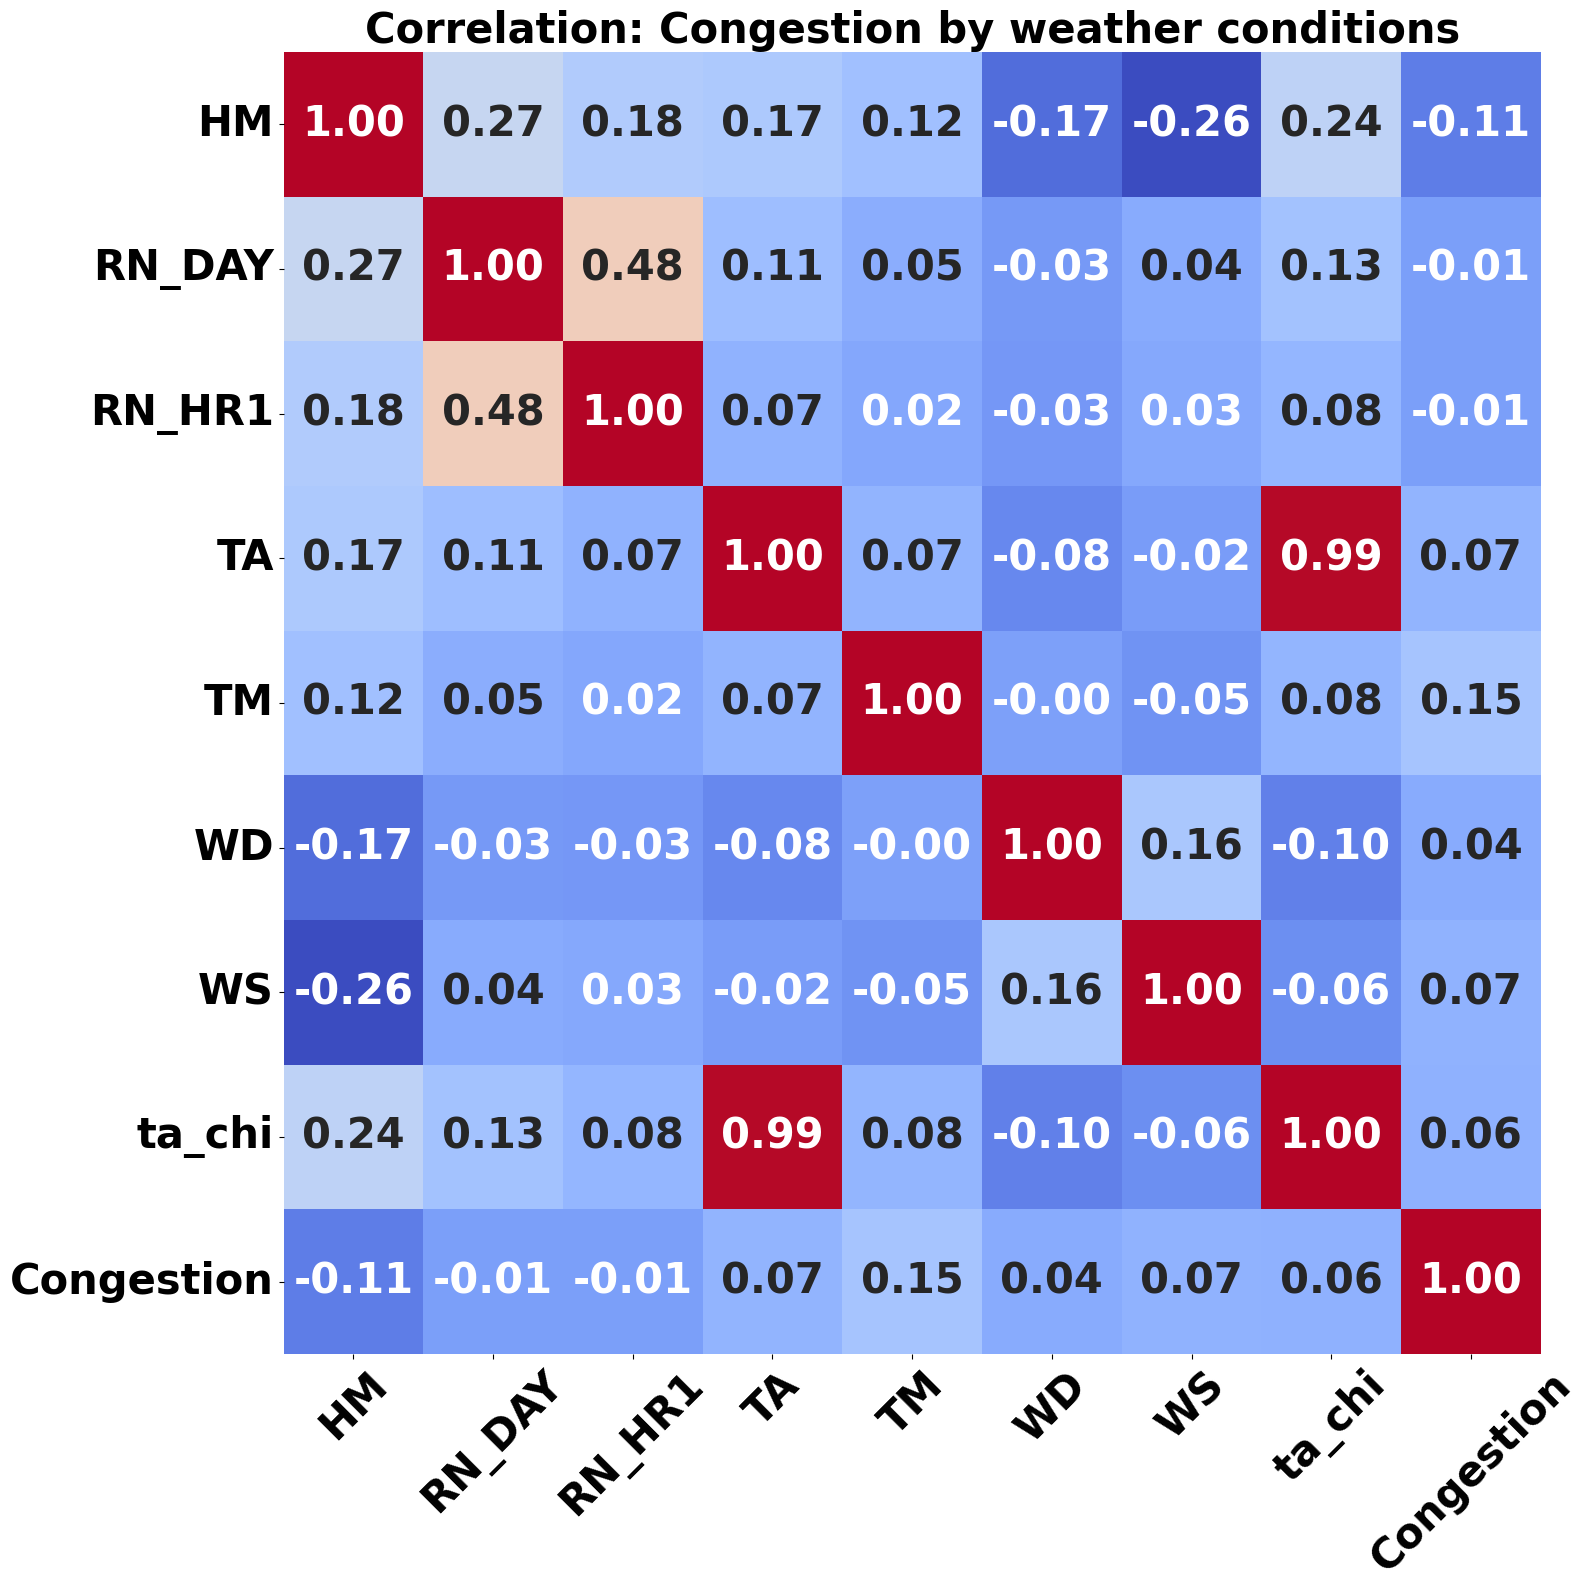

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
기상변수 =  ['HM', 'RN_DAY', 'RN_HR1','TA', 'TM', 'WD','WS','ta_chi']
cols = 기상변수 + ['Congestion']
df_corr = df[cols].copy()

corr_tab = df_corr.corr()

plt.figure(figsize=(16, 16))
sns.heatmap(
    corr_tab,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar=False,
    annot_kws={'fontsize': 30, 'fontweight': 'bold'}
)

plt.title("Correlation: Congestion by weather conditions", fontsize=30, fontweight='bold')
plt.xticks(fontsize=30, fontweight='bold', rotation=45)
plt.yticks(fontsize=30, fontweight='bold', rotation=0)

plt.tight_layout()
plt.show()

# 2. VIF(분산팽창계수)를 계산하여 변수 간의 다중공선성 확인

In [17]:
df_corr = df_corr.drop(columns='TM', axis=1)

In [18]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_const = sm.add_constant(df_corr)

# VIF 계산
vif_data = pd.DataFrame({
    'feature': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i)
            for i in range(X_const.shape[1])]
})

print(vif_data)

      feature        VIF
0       const  24.695543
1          HM   1.488166
2      RN_DAY   1.379684
3      RN_HR1   1.310486
4          TA  71.050437
5          WD   1.056781
6          WS   1.152232
7      ta_chi  73.175548
8  Congestion   1.023811


- 1 ~ 5: 특별히 문제 없음
- 5 ~ 10: 다소 주의 필요
- 10 이상: 심각한 다중공선성 의심

| 피처         | VIF   | 해석                                                  |
| ---------- | ----- | --------------------------------------------------- |
| HM         | 1.49  | 문제 없음                                               |
| RN\_DAY    | 1.38  | 문제 없음                                               |
| RN\_HR1    | 1.31  | 문제 없음                                               |
| TA         | 71.05 | 매우 높은 다중공선성 (다른 변수와 강한 상관)                          |
| WD         | 1.06  | 문제 없음                                               |
| WS         | 1.15  | 문제 없음                                               |
| ta\_chi    | 73.18 | 매우 높은 다중공선성 (특히 TA와 거의 중복 정보)                       |
| Congestion | 1.02  | (종속변수 포함 시) 문제 없음                                   |


TA와 ta_chi는 역시 서로 다중공선성이 높아서 둘의 관계를 고려해야 함

# 3. 주성분 회귀 (Principal Component Regression, PCR)

다중공선성이 강할 때, 주성분 분석(PCA) 후 주요 성분을 이용해 회귀모델 구축



In [21]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = df_corr.drop(columns='Congestion', axis=1)
y = df_corr['Congestion']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 2) PCR 파이프라인: 표준화 → PCA → 선형회귀
n_components = 2  # 2차원으로 축소해야 시각적으로 해석하기 용이해서 2차원으로 차원을 축소함.
pcr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('lr', LinearRegression())
])

# 3) 모델 학습 및 평가
pcr.fit(X_train, y_train)
print("Train R²:", pcr.score(X_train, y_train))
print("Test  R²:", pcr.score(X_test, y_test))

Train R²: 0.005952862764024736
Test  R²: 0.005921366025543495


- 2차원으로 차원 축소를 했으나 Train, test셋의 설명력이 거의 없음

#4. 정준상관분석 (Canonical Correlation Analysis, CCA)

In [24]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

X = df_corr[['HM','RN_DAY','RN_HR1','TA','WD','WS','ta_chi']].values
Y = df_corr[['Congestion']].values   # DataFrame으로 가져오면 이미 2D!

# 2) 표준화
scaler_x = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(Y)  # Y가 (n,1) 형태이므로 바로 사용 가능

X_s = scaler_x.transform(X)
Y_s = scaler_y.transform(Y)

# 3) CCA 적합
n_components = 1
cca = CCA(n_components=n_components)
cca.fit(X_s, Y_s)

# 4) 정준변수 추출 및 상관 확인
X_c, Y_c = cca.transform(X_s, Y_s)
corr = np.corrcoef(X_c.T, Y_c.T)[0,1]
print(f'첫 번째 정준변수 간 상관계수: {corr:.3f}')

첫 번째 정준변수 간 상관계수: 0.153


첫 번째 정준변수는 기상 변수들과 Congestion을 각각 가장 높은 상관을 갖도록 선형 결합한 새로운 변수 축이다. 정준상관계수가 0.153이라는 것은, 가장 상관이 큰 축을 찾아도 X 피처들의 선형 결합이 Congestion의 변동을 거의 설명하지 못함을 의미한다. 따라서 기상변수만으로는 Congestion과의 관계가 매우 약하며, 추가적인 피처 엔지니어링이 필요하며 Congestion을 잘 설명하는 추가적인 변수들이 필요하다.

# 5. 다중회귀모델
- 예측 모델의 성능을 위해서가 아닌 개별의 기상변수가 혼잡도에 어떤 영향을 미치는지 통계적 유의성과 효과 크기를 해석하기 위해 다중회귀모델을 사용하였음

In [25]:
import statsmodels.api as sm

features = ['HM', 'RN_DAY', 'RN_HR1', 'TA', 'WD', 'WS', 'ta_chi']
X = df_corr[features].apply(pd.to_numeric, errors='coerce')
y = df_corr.loc[X.index, 'Congestion'].astype(float)

# 2) 상수항 추가
X_const = sm.add_constant(X)

# 3) OLS 모델 적합
model = sm.OLS(y, X_const).fit()

# 4) 결과 요약
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Congestion   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                 5.491e+04
Date:                Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:50:35   Log-Likelihood:            -7.0570e+07
No. Observations:            16143988   AIC:                         1.411e+08
Df Residuals:                16143980   BIC:                         1.411e+08
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.9056      0.023   1089.478      0.0

피처별 통계적 방향성을 확인하고자 진행하였다.기상변수만 입력하였을 때는 모델의 결정계수(설명력)이 0.023으로 매우 낮음
- 표본 수가 1614만 건으로 매우 크기 때문에  모든 기상변수들의 유의확률이 유의하다고 나온 듯
- 회귀계수
- 기온(TA)은 1℃ 상승당 약 0.185만큼
- 풍속(WS)은 1 m/s 증가당 약 0.50만큼 혼잡도 상승
- HM이 한 단위 증가할 때마다 약 0.111만큼 혼잡도는 낮아짐
- 일평균 강우량(RN_DAY), 최근1시간 강우량(RN_HR1), 풍향(WD)도 모두 양(+)의 방향성을 가짐